# Célula 1: Imports e Feature Engineering

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv # A camada de Rede Neural de Grafos
import geopandas as gpd
import networkx as nx
import momepy
import numpy as np
import pandas as pd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler, LabelEncoder

print("Bibliotecas de Deep Learning carregadas.")

# 1. Carregar Dados (Seus dados Overture tratados)
# Certifique-se de que gdf_road está na memória (do passo anterior)
# Se não estiver, carregue o GeoJSON novamente
if 'gdf_road' not in locals():
    gdf_road = gpd.read_file('../dados/brutos/osmnx/the_bbox_osm_grafo.gpkg', layer='edges')
    gdf_road = gdf_road.to_crs("EPSG:31983")

print(f'{gdf_road['highway'].unique().tolist()}')

# 2. Criar Features Geométricas (O que define a rua?)
print("Criando características geométricas...")

# A) Comprimento Normalizado
gdf_road['len_norm'] = gdf_road.geometry.length

# B) Linearidade (Reta vs Curva)
def get_linearity(geom):
    try:
        dist = Point(geom.coords[0]).distance(Point(geom.coords[-1]))
        return dist / geom.length if geom.length > 0 else 0
    except:
        return 0
gdf_road['linearity'] = gdf_road.geometry.apply(get_linearity)

# 3. Converter para Grafo (Para pegar a conectividade)
print("Convertendo para Grafo Dual (Onde cada NÓ é uma RUA)...")
# GNNs de ruas geralmente usam o "Dual Graph" ou "Line Graph":
# No grafo normal: Ruas são arestas.
# No grafo dual: Ruas viram NÓS. Se duas ruas se tocam, existe uma aresta entre elas.
# Isso permite classificar os NÓS (que são as ruas).

G_primal = momepy.gdf_to_nx(gdf_road, approach='primal')
G_dual = momepy.gdf_to_nx(gdf_road, approach='dual') # Momepy faz essa mágica

print(f"Grafo Dual criado: {len(G_dual.nodes)} ruas interconectadas.")

Bibliotecas de Deep Learning carregadas.
['tertiary', 'residential', 'unclassified', 'trunk', 'trunk_link', 'primary', 'living_street', "['unclassified', 'residential']", 'tertiary_link', 'secondary', 'primary_link', 'secondary_link', "['living_street', 'residential']", 'busway', "['primary_link', 'primary']", "['unclassified', 'tertiary']"]
Criando características geométricas...
Convertendo para Grafo Dual (Onde cada NÓ é uma RUA)...
Grafo Dual criado: 59702 ruas interconectadas.


In [2]:
gdf_road.head(3)

,id,version,sources,subtype,class,names,connectors,routes,subclass_rules,access_restrictions,...,prohibited_transitions,rail_flags,road_surface,road_flags,speed_limits,width_rules,subclass,geometry,len_norm,linearity
0,6d775c41-5cf2-493e-b402-cfcbd8972262,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,unclassified,None,[{'connector_id': 'eaaeee83-1ec8-4c2f-a46e-dde...,None,None,None,...,None,None,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (723376.977 9408354.072, 723403.887...",720.449364,0.973612
1,aec4047f-e9b3-4c2b-ba48-c1c065ffc97e,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,unclassified,None,[{'connector_id': '89a3c9a6-e65e-4102-888f-499...,None,None,None,...,None,None,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (724465.971 9415641.369, 724036.799...",2081.823556,0.999003
2,fabe85df-cfbc-4adc-a6e7-7a41c44f39c6,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,unclassified,None,[{'connector_id': 'c32213b5-fe58-4ca9-a910-32a...,None,None,None,...,None,None,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (723945.476 9414665.026, 723870.213...",1099.216268,0.968581


# Célula 2: Transformação em Tensores PyTorch

In [3]:
# 1. Preparar Rótulos (Target)
# Vamos ensinar o modelo com as classes que confiamos
classes_validas = [
    'motorway', 'trunk', 'primary', 'secondary', 'tertiary', 
    'residential', 'living_street', 'service', 'pedestrian', 'footway'
]

# Encoder: Transforma texto ('primary') em número (0, 1, 2...)
le = LabelEncoder()
# Treina o encoder apenas nas classes conhecidas para garantir a ordem
le.fit(classes_validas) 

# Função para codificar (lidando com unknown)
def encode_target(val):
    if val in classes_validas:
        return le.transform([val])[0]
    return -1 # -1 será nossa marca de "Desconhecido"

gdf_road['y_encoded'] = gdf_road['class'].apply(encode_target)

# 2. Alinhar o Grafo Dual com o GeoDataFrame
# O G_dual tem nós cujos IDs correspondem ao índice do gdf_road (geralmente)
# Vamos garantir a ordem
mapeamento_nos = {node: i for i, node in enumerate(G_dual.nodes)}
adj = nx.to_pandas_adjacency(G_dual) # Matriz de adjacência (quem toca quem)

# 3. Criar Tensores (Matrizes)
# Features (X): [Comprimento, Linearidade]
# Precisamos pegar as features na mesma ordem dos nós do grafo
indices_ordenados = list(G_dual.nodes) # IDs das ruas
# Pega as linhas do GDF correspondentes a esses IDs (se o momepy usou índice)
# Nota: O momepy approach='dual' geralmente usa tuplas ou índices. 
# Vamos assumir que conseguimos mapear de volta.
# SIMPLIFICAÇÃO: Vamos usar a ordem do GDF e assumir que o grafo respeita.
features = gdf_road[['len_norm', 'linearity']].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

x = torch.tensor(features_scaled, dtype=torch.float)

# Rótulos (Y)
y = torch.tensor(gdf_road['y_encoded'].values, dtype=torch.long)

# Arestas (Edge Index) - A estrutura da rede
# Converte o grafo networkx para formato PyG
from torch_geometric.utils import from_networkx
# Cuidado: from_networkx espera que os nós sejam numerados 0..N ou tenhamos sorte
# Vamos converter o G_dual para ter rótulos inteiros 0..N
G_dual_int = nx.convert_node_labels_to_integers(G_dual)
pyg_graph = from_networkx(G_dual_int)
edge_index = pyg_graph.edge_index

# 4. Máscaras de Treino (Train Mask)
# Onde y != -1 (Conhecido) -> Treino
# Onde y == -1 (Desconhecido) -> Predição
train_mask = y != -1
predict_mask = y == -1

print(f"Total para Treino: {train_mask.sum().item()}")
print(f"Total para Predizer: {predict_mask.sum().item()}")

# Objeto Final de Dados
data = Data(x=x, edge_index=edge_index, y=y)
data.train_mask = train_mask
data.predict_mask = predict_mask

print("Dados prontos para a Rede Neural.")

Total para Treino: 60017
Total para Predizer: 6469
Dados prontos para a Rede Neural.


# Célula 3: Definição e Treinamento do Modelo

In [4]:
# 1. Definir a Arquitetura da Rede Neural
class StreetClassifier(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        # Primeira camada de convolução (olha vizinhos imediatos)
        self.conv1 = GCNConv(num_features, 16)
        # Segunda camada (olha vizinhos dos vizinhos)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Camada 1 + Ativação ReLU
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training) # Evita decorar dados (overfitting)

        # Camada 2
        x = self.conv2(x, edge_index)

        # Saída: Probabilidade de ser cada classe (Log Softmax)
        return F.log_softmax(x, dim=1)

# 2. Inicializar
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StreetClassifier(num_features=2, num_classes=len(classes_validas)).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print("Iniciando treinamento (Isso pode levar alguns segundos)...")

# 3. Loop de Treinamento
model.train()
for epoch in range(200): # 200 épocas (passadas)
    optimizer.zero_grad()
    out = model(data)
    
    # Calcula erro apenas nas ruas conhecidas (Train Mask)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Época {epoch}: Erro (Loss) = {loss.item():.4f}")

print("Treinamento Concluído!")

Iniciando treinamento (Isso pode levar alguns segundos)...
Época 0: Erro (Loss) = 2.2379
Época 20: Erro (Loss) = 1.2102
Época 40: Erro (Loss) = 1.0439
Época 60: Erro (Loss) = 1.0153
Época 80: Erro (Loss) = 1.0051
Época 100: Erro (Loss) = 1.0022
Época 120: Erro (Loss) = 0.9981
Época 140: Erro (Loss) = 0.9968
Época 160: Erro (Loss) = 0.9982
Época 180: Erro (Loss) = 0.9952
Treinamento Concluído!


# Célula 4: Predição e Exportação

In [6]:
model.eval() # Modo de avaliação (desliga dropout)
_, pred = model(data).max(dim=1) # Pega a classe com maior probabilidade

# Recupera os nomes das classes (número -> texto)
pred_classes = le.inverse_transform(pred.cpu().numpy())

# Atualiza o GeoDataFrame
print("Aplicando predições...")

# Cria coluna nova
gdf_road['class_ml_gnn'] = gdf_road['class']

# Onde era desconhecido (predict_mask), coloca o valor predito
# Precisamos garantir que o índice bate. Se usamos convert_node_labels_to_integers,
# a ordem 0..N bate com a ordem das linhas do gdf_road se não houve filtro.
# Supondo alinhamento direto:
mask_np = data.predict_mask.cpu().numpy()
gdf_road.loc[mask_np, 'class_ml_gnn'] = pred_classes[mask_np]

# Substitui a coluna oficial para usarmos no cálculo de velocidade
gdf_road['class'] = gdf_road['class_ml_gnn']

print("Classificação via GNN finalizada.")
print("\nExemplo de ruas 'unknown' que foram classificadas:")
print(gdf_road[mask_np][['id', 'len_norm', 'class']].head(10))

# AGORA SIM: Você deve rodar a célula de RECALCULAR VELOCIDADES e RECRIAR GRAFO
# (Aquelas mesmas que passei na mensagem anterior)

Aplicando predições...
Classificação via GNN finalizada.

Exemplo de ruas 'unknown' que foram classificadas:
                                     id     len_norm        class
0  6d775c41-5cf2-493e-b402-cfcbd8972262   720.449364  residential
1  aec4047f-e9b3-4c2b-ba48-c1c065ffc97e  2081.823556  residential
2  fabe85df-cfbc-4adc-a6e7-7a41c44f39c6  1099.216268  residential
3  7b0e2bea-3908-4ba4-93da-6f9ff6f06056   540.386635  residential
4  87309c7e-7195-4237-9d45-42570008a3b4   665.671536  residential
5  4797c7d7-c1bf-4919-95c9-b5a036922ae0   973.132207  residential
6  7327becf-7849-420c-84dc-a397faeafc76    57.470799  residential
7  31516b8b-452e-44cc-8a4d-914b0a0bfe5d  3354.665865  residential
8  03066505-ac3f-4fe4-bff6-7ca75579a32f  1468.727184  residential
9  1adc41b1-2057-4f0c-9234-19a8b2a248b9    97.219294  residential


In [12]:
gdf_road.head(10)

,id,version,sources,subtype,class,names,connectors,routes,subclass_rules,access_restrictions,...,road_surface,road_flags,speed_limits,width_rules,subclass,geometry,len_norm,linearity,y_encoded,class_ml_gnn
0,6d775c41-5cf2-493e-b402-cfcbd8972262,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,residential,None,[{'connector_id': 'eaaeee83-1ec8-4c2f-a46e-dde...,None,None,None,...,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (723376.977 9408354.072, 723403.887...",720.449364,0.973612,-1,residential
1,aec4047f-e9b3-4c2b-ba48-c1c065ffc97e,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,residential,None,[{'connector_id': '89a3c9a6-e65e-4102-888f-499...,None,None,None,...,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (724465.971 9415641.369, 724036.799...",2081.823556,0.999003,-1,residential
2,fabe85df-cfbc-4adc-a6e7-7a41c44f39c6,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,residential,None,[{'connector_id': 'c32213b5-fe58-4ca9-a910-32a...,None,None,None,...,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (723945.476 9414665.026, 723870.213...",1099.216268,0.968581,-1,residential
3,7b0e2bea-3908-4ba4-93da-6f9ff6f06056,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,residential,None,[{'connector_id': '3d80bce1-d842-459a-9195-f84...,None,None,None,...,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (726129.04 9412722.319, 726055.54 9...",540.386635,0.999254,-1,residential
4,87309c7e-7195-4237-9d45-42570008a3b4,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,residential,None,[{'connector_id': '39621dac-1801-466a-bcb9-182...,None,None,None,...,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (726305.053 9412149.253, 726254.563...",665.671536,0.779061,-1,residential
5,4797c7d7-c1bf-4919-95c9-b5a036922ae0,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,residential,None,[{'connector_id': '5562e7a4-1419-4285-882f-8dd...,None,None,None,...,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (728869.682 9412712.631, 728716.608...",973.132207,0.999954,-1,residential
6,7327becf-7849-420c-84dc-a397faeafc76,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,residential,None,[{'connector_id': '5562e7a4-1419-4285-882f-8dd...,None,None,None,...,None,None,None,None,None,"LINESTRING (728869.682 9412712.631, 728902.149...",57.470799,1.000000,-1,residential
7,31516b8b-452e-44cc-8a4d-914b0a0bfe5d,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,residential,None,[{'connector_id': '3d80bce1-d842-459a-9195-f84...,None,None,None,...,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (726129.04 9412722.319, 726267.04 9...",3354.665865,0.999168,-1,residential
8,03066505-ac3f-4fe4-bff6-7ca75579a32f,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,residential,None,[{'connector_id': '0fc7ae21-1555-48f4-b7dd-211...,None,None,None,...,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (724562.803 9415632.703, 724540.945...",1468.727184,0.859802,-1,residential
9,1adc41b1-2057-4f0c-9234-19a8b2a248b9,1,"[{'property': '', 'dataset': 'OpenStreetMap', ...",road,residential,None,[{'connector_id': '0fc7ae21-1555-48f4-b7dd-211...,None,None,None,...,"[{'value': 'unpaved', 'between': None}]",None,None,None,None,"LINESTRING (724562.803 9415632.703, 724465.971...",97.219294,1.000000,-1,residential


# Célula: Estatísticas Comparativas (Validação do Modelo)

Gerando estatísticas de validação...


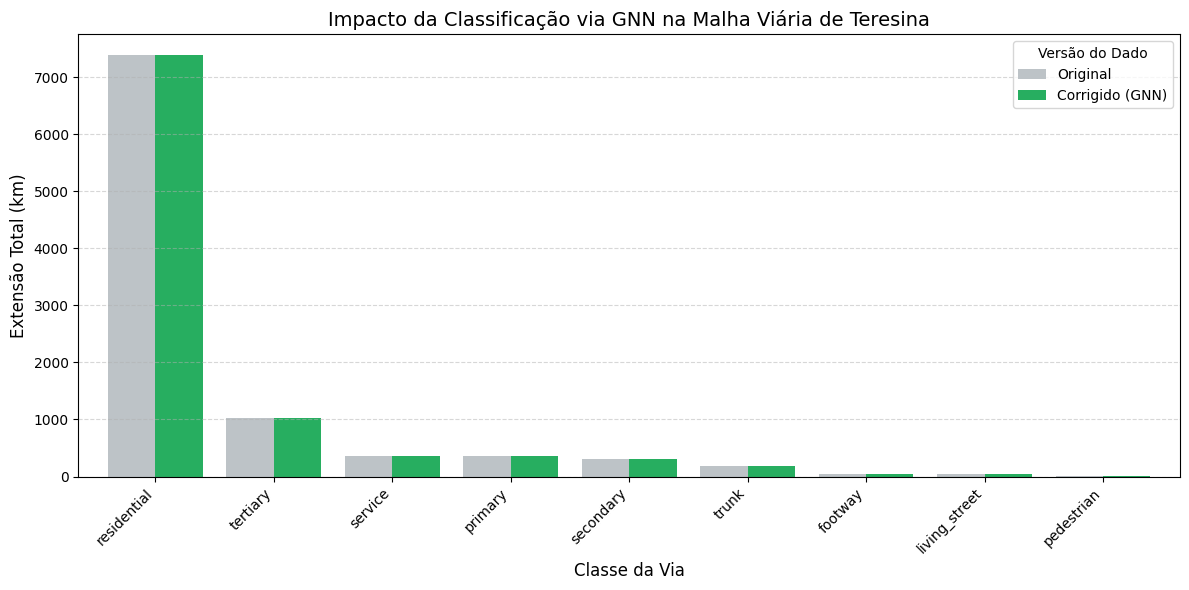


--- RESUMO DA MUDANÇA (em KM) ---
Series([], dtype: float64)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Gerando estatísticas de validação...")

# 1. Preparar dados para comparação
# Vamos somar a quilometragem por classe (mais relevante que contagem de linhas)
stats_antes = gdf_road.groupby('class')['len_norm'].sum() / 1000 # em KM
stats_depois = gdf_road.groupby('class_ml_gnn')['len_norm'].sum() / 1000       # em KM

# Cria um DataFrame único para plotagem
df_stats = pd.DataFrame({'Original': stats_antes, 'Corrigido (GNN)': stats_depois}).fillna(0)

# Ordena para ficar bonito no gráfico (do maior para o menor no corrigido)
df_stats = df_stats.sort_values(by='Corrigido (GNN)', ascending=False)

# 2. Visualização Gráfica
fig, ax = plt.subplots(figsize=(12, 6))

df_stats.plot(kind='bar', ax=ax, width=0.8, color=['#bdc3c7', '#27ae60'])

plt.title("Impacto da Classificação via GNN na Malha Viária de Teresina", fontsize=14)
plt.ylabel("Extensão Total (km)", fontsize=12)
plt.xlabel("Classe da Via", fontsize=12)
plt.legend(title="Versão do Dado")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 3. Printar números absolutos para você citar no texto
print("\n--- RESUMO DA MUDANÇA (em KM) ---")
diff = df_stats['Corrigido (GNN)'] - df_stats['Original']
print(diff[diff != 0]) # Mostra apenas o que mudou